# Optimal allocation

In this notebook, we will use different algorithms to learn when it is best to buy and sell an asset.

Here is the setup:
* action: short, neutral, or long the asset ($=0,1,2$)
* state: the asset price (on a finite grid) & the current position 
* environment: generate new prices and transaction costs

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

We first create a class defining the behavior of the environment. Similar logic as the `gym` environment from *OpenAI*, see https://gym.openai.com/.

The $Q$-table is contructed as follows:

| state (prev. action \& price) / action        | $a_0=0$      | $a_1=1$      | $a_2=2$      |
| :------------------ | :----------: | -----------: | -----------: | 
| $s_0=(0,p_0)$       | $Q(s_0,a_0)$ | $Q(s_0,a_1)$ | $Q(s_0,a_2)$ | 
| $s_1=(0,p_1)$       | $Q(s_1,a_0)$ | $Q(s_1,a_1)$ | $Q(s_1,a_2)$ | 
| $s_2=(0,p_2)$       | $Q(s_2,a_0)$ | $Q(s_2,a_1)$ | $Q(s_2,a_2)$ | 
| $\vdots$            | $\vdots$     | $\vdots$     | $\vdots$     | 
| $s_{n-1}=(2,p_{n-1})$  | $Q(s_{n-1},a_0)$ | $Q(s_{n-1},a_1)$ | $Q(s_{n-1},a_2)$ | 
| $s_n=(2,p_n)$       | $Q(s_n,a_0)$ | $Q(s_n,a_1)$ | $Q(s_n,a_2)$ | 

In [4]:
class myTradingEnv:
    
    max_price = 200. ## max price
    mult = 50. ## price increment
    n_prices = int(max_price/mult + 1)
    n_actions = 3 ## number of possible actions = (short, neutral, long)
    n_states = n_prices * n_actions ## state = (# of prices) x (# of actions)
    
    def __init__(self, max_steps):
        """
        @param max_steps is the maximum number of states
        """
        self.max_steps = max_steps
        
    def init_q(self):
        """
        initialize the state-action Q matrix
        -> rows = states (prices X previous actions)
        -> columns = actions (short, neutral, long)
        """
        q = np.random.rand(self.n_states, self.n_actions)
        return q
         
    def get_state(self):
        price = self.prices[self.last_step]
        action = self.last_action
        idx = int(price/self.mult + action * self.n_prices)
        return(idx)
    
    def reset(self):
        self.prices = np.zeros(self.max_steps)
        self.actions = np.zeros(self.max_steps)
        self.rewards = np.zeros(self.max_steps)
        ##---------
        ## NB: random initial state helps a lot!
        ##---------
        self.prices[0] = self.mult*np.random.randint(self.max_price/self.mult+1) ## random inital price
        self.last_action = np.random.randint(self.n_actions) ## random initial position
        ##
        self.last_step = 0
        self.current_state = self.get_state()
        return self.current_state
    
    def step(self, a):
        """
        generate the new state and the reward
        @param a is the action taken by the agent
        -----
        implemented:
        -> mean-reverting process
        -----
        NOT implemented:
        -> reward function
        -> transaction cost (later)
        -> borrowing cost (optional)
        -> price impact (optional)
        -> agent risk-aversion (optional)
        """
        ## get previous values
        i = self.last_step
        x = self.prices[i]
        
        ## move to next step
        if 0 < x < self.max_price:
            birth = np.random.rand() <= 0.5 + 0.1*(1. - x/self.max_price)
            death = np.random.rand() <= 0.5 + 0.1*(x / self.max_price)
            # We update the population size
            x_new = x + self.mult*birth - self.mult*death
        else:
            ## repulsive boundaries
            if x == 0:
                x_new = self.mult
            else:
                x_new = self.max_price - self.mult
        
        ##----------
        ## TODO: implement reward
        ##----------
        reward = (x_new - x) * (a - 1)        
        ## save action
        self.actions[i] = a
        self.last_action = a
        
        ## update step
        i += 1 
        self.last_step = i
        ## save price
        self.prices[i] = x_new
        ## save reward
        self.rewards[i] = reward
        
        ## update current state
        s_ = self.get_state()
        self.current_state = s_
        
        ## output some useful information
        info = ""
        
        ## end of the time series?
        if i == self.max_steps - 1:
            done = True
        else:
            done = False
            
        return s_, reward, done, info
    
    def simulate(self):
        """
        FOR ILLUSTRATION ONLY
        simulate a price trajectory, assuming no position
        """
        self.reset()
        for t in range(self.max_steps - 1):
            self.step(0)

Let's simulate the environment.

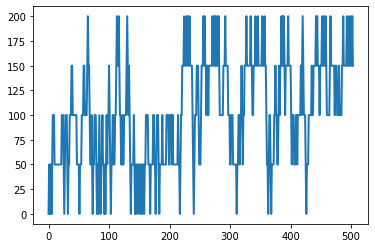

In [5]:
env = myTradingEnv(504) ## create environment
env.simulate() ## simulate some trajectory
plt.plot(env.prices, lw=2)

The code below is a modified version examples produced by [this user](https://timetraveller-san.github.io/) (with corrections).

In [10]:
def epsilon_greedy(Q, epsilon, n_actions, s):
    """
    @param Q Q values state x action -> value
    @param epsilon for exploration
    @param n_actions number of states
    @param s current state
    """
    if np.random.rand() > epsilon:
        ##----------
        ## TODO
        ##----------
        action = np.argmax(Q[s, :])
    else:
        ##----------
        ## TODO
        ##----------
        action = np.random.randint(0, n_actions, s)
    return action

def test_agent(Q, env, n_tests, seed=0):
    """
    This function will be used later when we want to test the fitted tables.
    @param Q q-table
    @param env trading env
    @param n_tests number of simulations to run
    @param seed random seed initialization
    """
    np.random.seed(seed)
    results = []
    for test in range(n_tests):
        print(f"Test #{test}")
        s = env.reset()
        n_actions = env.n_actions
        epsilon = 0 ## no exploration!
        total_reward = 0
        done = False
        while not done:
            a = epsilon_greedy(Q, epsilon, n_actions, s)
            #print(f"State {s} Action {a}")
            s, reward, done, info = env.step(a)
            total_reward += reward
        print(f"Episode reward: {total_reward}")
        results.append([env.prices, env.actions, total_reward])
    return(results)

## SARSA

In [16]:
def sarsa(alpha, gamma, epsilon, n_episodes, max_steps, test=False):
    """
    @param alpha learning rate
    @param gamma decay factor
    @param epsilon for exploration
    @param episodes number of train episodes
    @param max_steps for max step in each episode
    """
    env = myTradingEnv(max_steps)
    n_actions = env.n_actions
    Q = env.init_q()
    timestep_reward = []
    for episode in range(n_episodes):
        print(f"Episode: {episode}")
        total_reward = 0
        ##----------
        ## TODO
        ##----------
        ## learning rate update for this episode
        alpha_e = alpha / (1 + episode)
        ## prepare env and return current state
        s = env.reset()
        ## first action
        ##----------
        ## TODO
        ##----------
        a = epsilon_greedy(Q, epsilon, n_actions, s)
        t = 0
        done = False
        while t < env.max_steps:
            t += 1
            s_, reward, done, info = env.step(a)
            total_reward += reward
            ##----------
            ## TODO
            ##----------
            ## A_{t+1} action
            a_ = epsilon_greedy(Q, epsilon, n_actions, s_)
            if done:
                ##----------
                ## TODO
                ##----------
                Q[s, a] = Q[s,a] + alpha_e*(reward + - Q[s,a])
            else:
                ##----------
                ## TODO
                ##----------
                Q[s, a] = Q[s,a] + alpha_e*(reward + gamma*Q[s_,a_] - Q[s,a])
                
            ##----------
            ## TODO
            ##----------
            ## next period simulation (state + policy/action)
            s, a = s_, a_
            if done:
                print(f"This episode took {t} timesteps and reward {total_reward}")
                timestep_reward.append(total_reward)
                break
    return timestep_reward, Q, env

## Q-learning

In [7]:
def qlearning(alpha, gamma, epsilon, n_episodes, max_steps, test=False):
    """
    @param alpha learning rate
    @param gamma decay factor
    @param epsilon for exploration
    @param episodes number of train episodes
    @param max_steps for max step in each episode
    """
    env = myTradingEnv(max_steps)
    n_actions = env.n_actions
    Q = env.init_q()
    timestep_reward = []
    for episode in range(n_episodes):
        print(f"Episode: {episode}")
        total_reward = 0
        ##----------
        ## TODO
        ##----------
        ## learning rate update for this episode
        alpha_e = alpha / (1 + episode)
        ## prepare env and return current state
        s = env.reset()
        ##----------
        ## TODO
        ##----------
        ## first action
        a = epsilon_greedy(Q, epsilon, n_actions, s)
        t = 0
        done = False
        while t < max_steps:
            t += 1
            s_, reward, done, info = env.step(a)
            total_reward += reward
            ##----------
            ## TODO
            ##----------
            ## A_{t+1} action
            a_ = epsilon_greedy(Q, 0, n_actions, s_)
            if done:
                ##----------
                ## TODO
                ##----------
                Q[s, a] = Q[s,a] +alpha_e*(reward - Q[s,a])
            else:
                ##----------
                ## TODO
                ##----------
                Q[s, a] = Q[s,a] +alpha_e*(reward + gamma*Q[s_,a_] - Q[s,a])
            ##----------
            ## TODO
            ##----------
            ## next period simulation (state + policy/action)
            s, a = s_, epsilon_greedy(Q, epsilon, n_actions, s)
            if done:
                print(f"This episode took {t} timesteps and reward {total_reward}")
                timestep_reward.append(total_reward)
                break
    return timestep_reward, Q, env

## Learn the optimal policy


In [17]:
##----------
## TODO: set hyper-parameters
##----------
alpha = 0.5 ## initial learning rate
gamma = 0.9 ## discount factor
epsilon = 0.1 ## policy randomization
n_episodes = 1000 ## number of episodes
max_steps = 252 * 2 ## number of days 

## runs
timestep_reward_1, Q_1, env_1 = sarsa(alpha, gamma, epsilon, n_episodes, max_steps)
timestep_reward_2, Q_2, env_2 = qlearning(alpha, gamma, epsilon, n_episodes, max_steps)

Episode: 0


ValueError: setting an array element with a sequence.

## Analyze results

Let's first see how the total reward evolved over episodes, we use a moving average to smooth the noise a little bit.

In [ ]:
## compute moving averages
weights = np.ones((100,))/100
ma_1 = np.convolve(timestep_reward_1, weights, mode='valid')
ma_2 = np.convolve(timestep_reward_2, weights, mode='valid')

plt.plot(ma_1)
plt.plot(ma_2)
plt.legend(["SARSA", "Q-learning"])
plt.show()

Let's now have a look at the optimal actions on a particular price trajectory.

In [ ]:
seed = 2
n_tests = 1
results_1 = test_agent(Q_1, env, n_tests, seed)
results_2 = test_agent(Q_2, env, n_tests, seed)

plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.title('prices')
plt.xticks([])
plt.plot(results_1[0][0])
plt.subplot(2,1,2)
plt.title('actions')
plt.plot(results_1[0][1] - 1) ## minus one 
plt.plot(results_2[0][1] - 1) ## minus one 
plt.legend(["SARSA", "Q-learning"])
plt.show()

Are the total rewards actually better with one method?

In [ ]:
seed = 2
n_tests = 200
results_1 = test_agent(Q_1, env, n_tests, seed);
results_2 = test_agent(Q_2, env, n_tests, seed);

rew_1, rew_2 = [], []
for i in range(n_tests):
    rew_1.append(results_1[i][2])
    rew_2.append(results_2[i][2])

In [ ]:
plt.figure()    
bins = np.histogram(np.hstack((rew_1, rew_2)), bins=50)[1] #get the bin edges
plt.hist(rew_1, bins, alpha=0.5)
plt.hist(rew_2, bins, alpha=0.5)
plt.legend(["SARSA", "Q-learning"])
plt.show()

### Sanity checks

Without frictions (such as rebalancing or shorting costs) the current position (last action) should not matter. Hence the Q matrix should converge to three similar block matrices.

With frictions, we should observe some differences.

In [ ]:
def plot_Q(Q, env):
    n_prices = env.n_prices
    Q_short = Q[:n_prices,:]
    Q_neutral = Q[n_prices:2*n_prices,:]
    Q_long = Q[2*n_prices:,:]
    Q_mats = np.concatenate([Q_short, np.nan*np.zeros((n_prices,1)), 
                             Q_neutral, np.nan*np.zeros((n_prices,1)),
                             Q_long], axis=1)
    plt.imshow(Q_mats, cmap='hot', interpolation='nearest')
    plt.colorbar() 
    plt.xticks([]), plt.yticks([])
    plt.show()

In [ ]:
plot_Q(Q_1, env_1)
plot_Q(Q_2, env_2)